In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.pardir))
sys.path.append(os.path.abspath(os.pardir)+"/src")

import random

import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection as ms
from mongoengine import connect, disconnect_all
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, log_loss, plot_roc_curve)
import pandas as pd

from src.utils import mongo_to_df, classification_report_as_df

np.random.seed(21)
random.seed(21)

### Preparando dados

In [3]:
connect("tcc")
df = mongo_to_df()
disconnect_all()

In [4]:
df.head()

_id  answer_1  answer_2  answer_3  \
0  FAKE_answer-17e4e593581240e29ab1e5c3427f945e      True     False     False   
1  FAKE_answer-02bee963584e45c6836d0aab2d3b5482      True     False     False   
2  FAKE_answer-a21c2c0c30ba487388c63e0645130120      True     False     False   
3  FAKE_answer-9010730262ad45babdf01293a03dbeed     False      True     False   
4  FAKE_answer-268c9cc5a4564d8f9252d37b5a056174      True     False      True   

   answer_4  answer_5  answer_6  answer_7  answer_8  answer_9  answer_10  \
0     False     False      True     False      True      True       True   
1     False      True     False     False      True     False       True   
2     False      True      True      True     False      True       True   
3      True     False     False     False     False     False      False   
4     False      True      True     False      True      True       True   

   answer_11  evaded                                     user_id  
0       True   False  FAKE_user-c0065f16f964447f854fec27f697ff50  
1       True    True  FAKE_user-b030f4a84c0e4223beb701aaf79dbf51  
2       True    True  FAKE_user-7d4fc1783f8f4964aeb1d8f6db3ba3a9  
3      False   False  FAKE_user-8190078bf6204bdaa58099048df24eb9  
4      False   False  FAKE_user-955bbf2a71f64941b9d62fa47cc9b47a

In [5]:
df = df.drop(columns=["_id", "user_id"])

In [6]:
# df = df.astype(int)

In [7]:
df.head()

answer_1  answer_2  answer_3  answer_4  answer_5  answer_6  answer_7  \
0      True     False     False     False     False      True     False   
1      True     False     False     False      True     False     False   
2      True     False     False     False      True      True      True   
3     False      True     False      True     False     False     False   
4      True     False      True     False      True      True     False   

   answer_8  answer_9  answer_10  answer_11  evaded  
0      True      True       True       True   False  
1      True     False       True       True    True  
2     False      True       True       True    True  
3     False     False      False      False   False  
4      True      True       True      False   False

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   answer_1   100 non-null    bool 
 1   answer_2   100 non-null    bool 
 2   answer_3   100 non-null    bool 
 3   answer_4   100 non-null    bool 
 4   answer_5   100 non-null    bool 
 5   answer_6   100 non-null    bool 
 6   answer_7   100 non-null    bool 
 7   answer_8   100 non-null    bool 
 8   answer_9   100 non-null    bool 
 9   answer_10  100 non-null    bool 
 10  answer_11  100 non-null    bool 
 11  evaded     100 non-null    bool 
dtypes: bool(12)
memory usage: 1.3 KB


In [9]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

### Separação dos dados

In [10]:
# X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

In [11]:
len(X_train)

80

# Métricas de avaliação

## Matriz de confusão

* Positivo Verdadeiro (True Positive – TP) que significa que a classe prevista e observada originalmente fazem parte da classe positiva;

* Falso Positivo (False Positive – FP) que significa que a classe predita retornou positivo mas a original observada era negativa;

* Negativo Verdadeiro (True Negative – TN) os valores preditos e observados fazem parte da categoria negativa;

* Falso Negativo (False Negative – FN) representa que o valor predito resultou na classe negativa mas o original observado era da classe positivo.

<img src="../img/matriz_confusao.png" width="400"/>

## Métricas de avaliação da Matriz de Confusão

* Acurácia (Acurary): Quantidade classificada como Positivos e Negativos corretamente, e pode ser formalizada em (TP + TN) / (TP + TN + FP + TN)

* Precisão (Precision): Quantidade Positiva classificada corretamente. E é calculada por TP / (TP + FP)

* Revocação (Recall): Taxa de valores classificada como Positivo, comparada com quantos deveriam ser. E pode ser calculada como TP / (TP + FN)

* Pontuação F1 (F1 SCORE): É calculado como a média harmônica entre Precisão e Recall, sendo sua formulação matemática representada por (2* TP) / (2* TP + FP + FN)


# Regressão Logística

In [12]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6


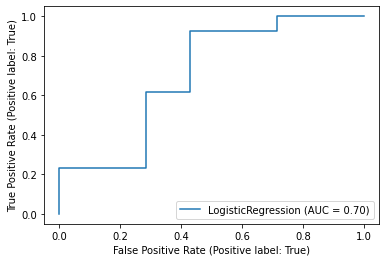

In [13]:
logistic_roc = plot_roc_curve(classifier, X_test, y_test)

In [14]:
print(confusion_matrix(y_test, y_pred))

[[4 3]
 [5 8]]


In [15]:
classification_report_as_df(y_test, y_pred)

precision    recall  f1-score  support
False          0.444444  0.571429  0.500000      7.0
True           0.727273  0.615385  0.666667     13.0
accuracy       0.600000  0.600000  0.600000      0.6
macro avg      0.585859  0.593407  0.583333     20.0
weighted avg   0.628283  0.600000  0.608333     20.0

# Árvore de decisão

In [16]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier()
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7


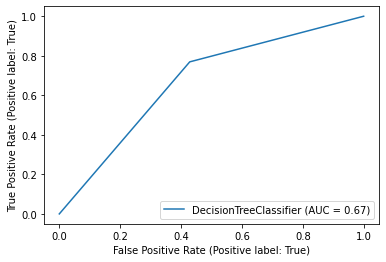

In [17]:
decision_tree_roc = plot_roc_curve(classifier, X_test, y_test)

In [18]:
print(confusion_matrix(y_test, y_pred))

[[ 4  3]
 [ 3 10]]


In [19]:
classification_report_as_df(y_test, y_pred)

precision    recall  f1-score  support
False          0.571429  0.571429  0.571429      7.0
True           0.769231  0.769231  0.769231     13.0
accuracy       0.700000  0.700000  0.700000      0.7
macro avg      0.670330  0.670330  0.670330     20.0
weighted avg   0.700000  0.700000  0.700000     20.0

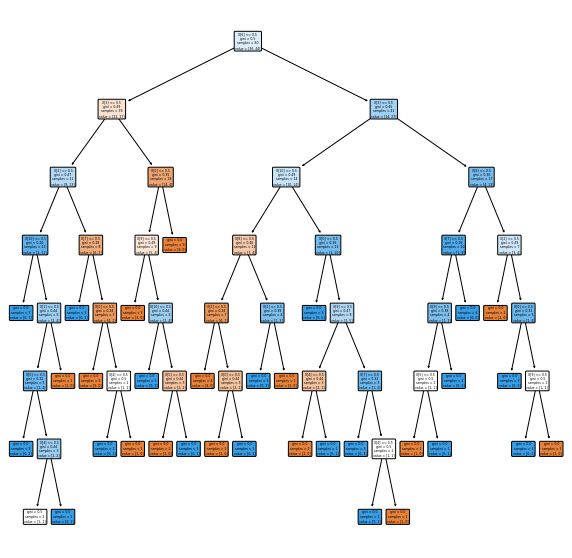

In [20]:
plt.figure(figsize=(10,10))
tree.plot_tree(classifier,filled=True,rounded=True, proportion=False, precision = 2)  
plt.savefig('../img/decision_tree.pdf',format='pdf',bbox_inches = "tight")

# Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
estimators = 100
classifier = RandomForestClassifier(n_estimators=estimators)
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.65


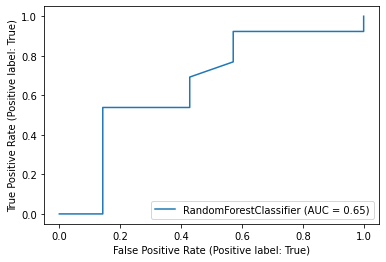

In [22]:
random_forest_roc = plot_roc_curve(classifier, X_test, y_test)

In [23]:
print(confusion_matrix(y_test, y_pred))

[[4 3]
 [4 9]]


In [24]:
classification_report_as_df(y_test, y_pred)

precision    recall  f1-score  support
False            0.5000  0.571429  0.533333     7.00
True             0.7500  0.692308  0.720000    13.00
accuracy         0.6500  0.650000  0.650000     0.65
macro avg        0.6250  0.631868  0.626667    20.00
weighted avg     0.6625  0.650000  0.654667    20.00

In [25]:
from sklearn.tree import export_graphviz
# Export as dot file
# export_graphviz(estimators, out_file='tree.dot', 
#                 feature_names = iris.feature_names,
#                 class_names = iris.target_names,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# uma arvore da floresta
estimator = classifier.estimators_[5]

export_graphviz(estimator, out_file='../img/random_forest.dot',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', '../img/random_forest.dot', '-o', '../img/random_forest.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = '../img/random_forest.png')

# Support Vector Machine

In [26]:
from sklearn.svm import SVC
classifier = SVC(random_state=42)
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.65


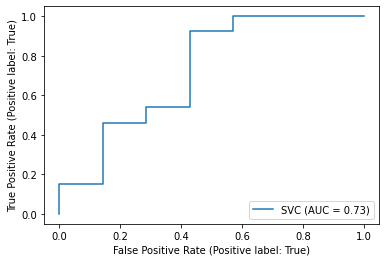

In [27]:
svm_roc = plot_roc_curve(classifier, X_test, y_test)

In [28]:
print(confusion_matrix(y_test, y_pred))

[[4 3]
 [4 9]]


In [29]:
classification_report_as_df(y_test, y_pred)

precision    recall  f1-score  support
False            0.5000  0.571429  0.533333     7.00
True             0.7500  0.692308  0.720000    13.00
accuracy         0.6500  0.650000  0.650000     0.65
macro avg        0.6250  0.631868  0.626667    20.00
weighted avg     0.6625  0.650000  0.654667    20.00

# Plotando ROC dos modelos

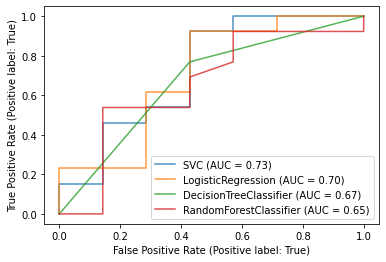

In [30]:
ax = plt.gca()
svm_roc.plot(ax=ax, alpha=0.8)
logistic_roc.plot(ax=ax, alpha=0.8)
decision_tree_roc.plot(ax=ax, alpha=0.8)
random_forest_roc.plot(ax=ax, alpha=0.8)